In [1]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
from scipy.sparse import csc_matrix

import os

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns



def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))



In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.



In [2]:
%%R -o features -o cells -o mtx
df_count = readRDS('./input/bonemarrow_cov250.rds')
mtx=as.matrix(df_count)
features = df_count@Dimnames[[1]]
cells = df_count@Dimnames[[2]]

R[write to console]: Loading required package: Matrix



In [3]:
# format the data
mtx=csc_matrix(mtx).transpose()
cells = cells.tolist()
features = features.tolist()

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

AnnData object with n_obs × n_vars = 1200 × 156311 


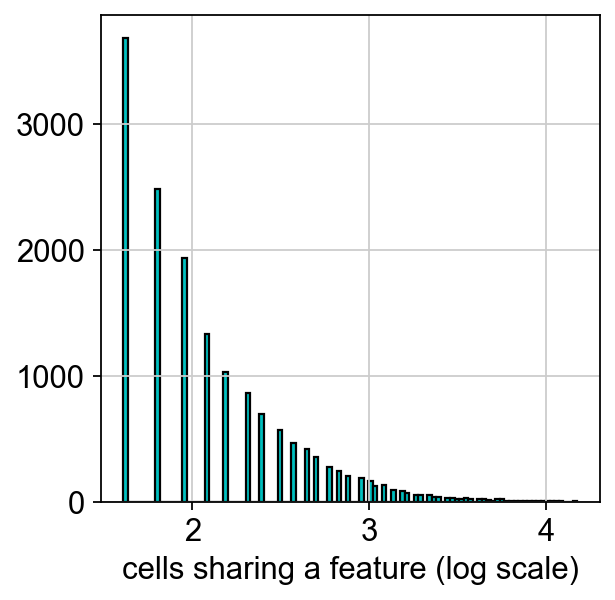

AnnData object with n_obs × n_vars = 1200 × 15872 
    obs: 'cell_type', 'n_features', 'nb_features'
    var: 'n_cells', 'commonness'


... storing 'cell_type' as categorical


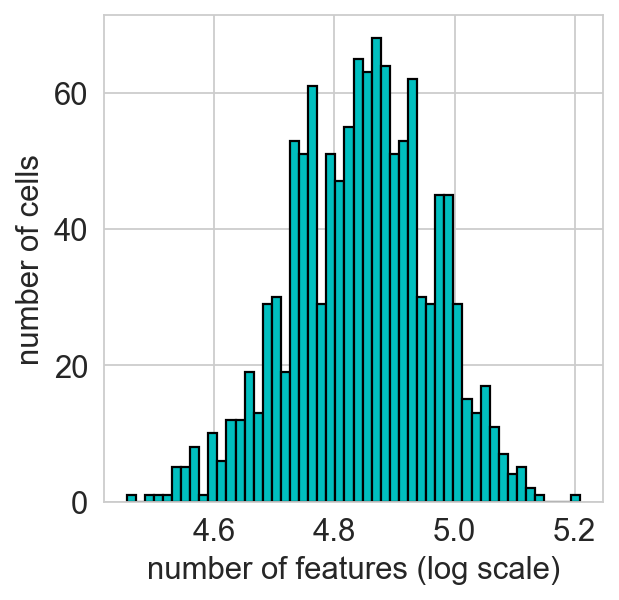

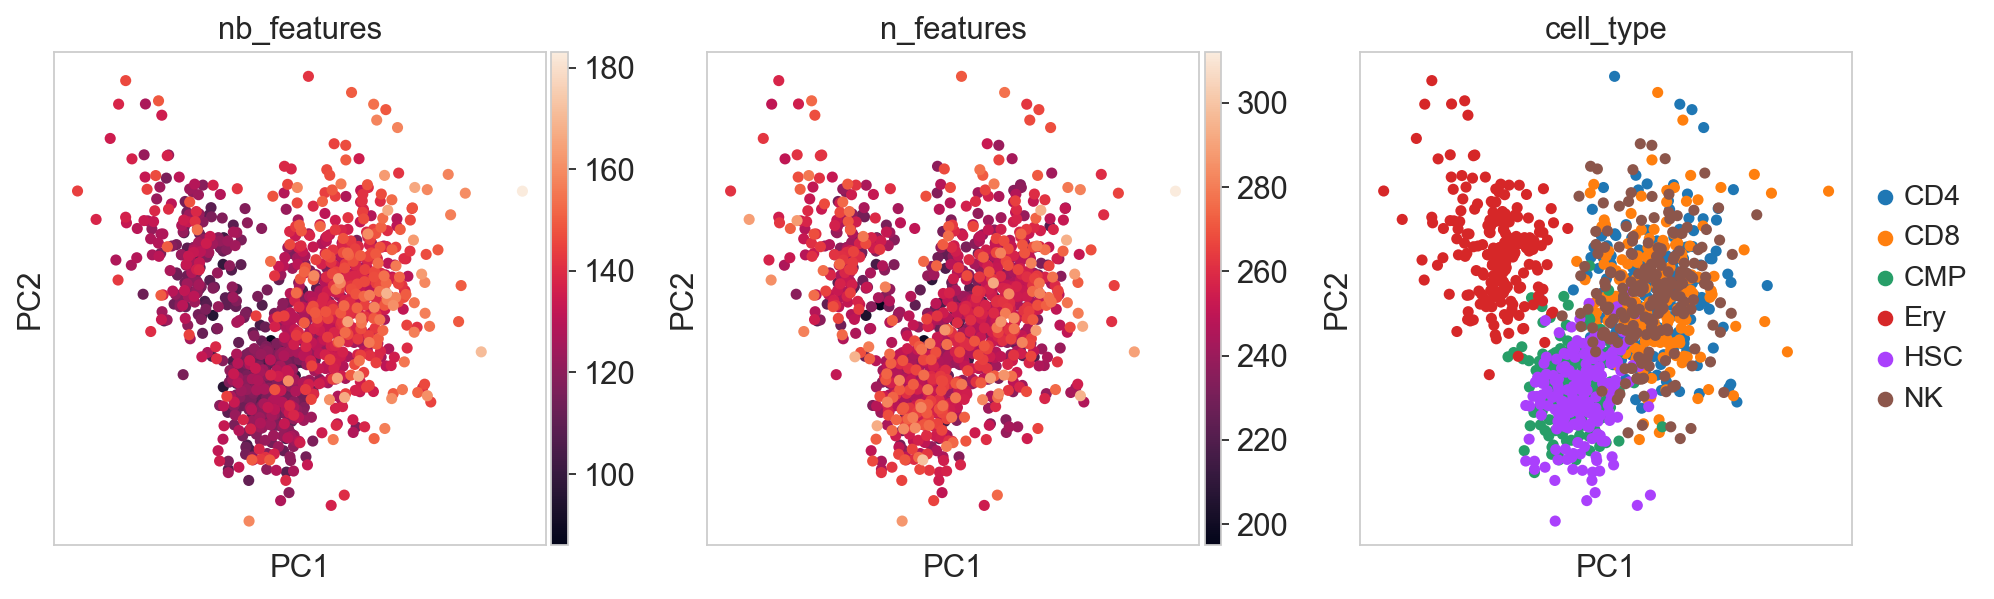

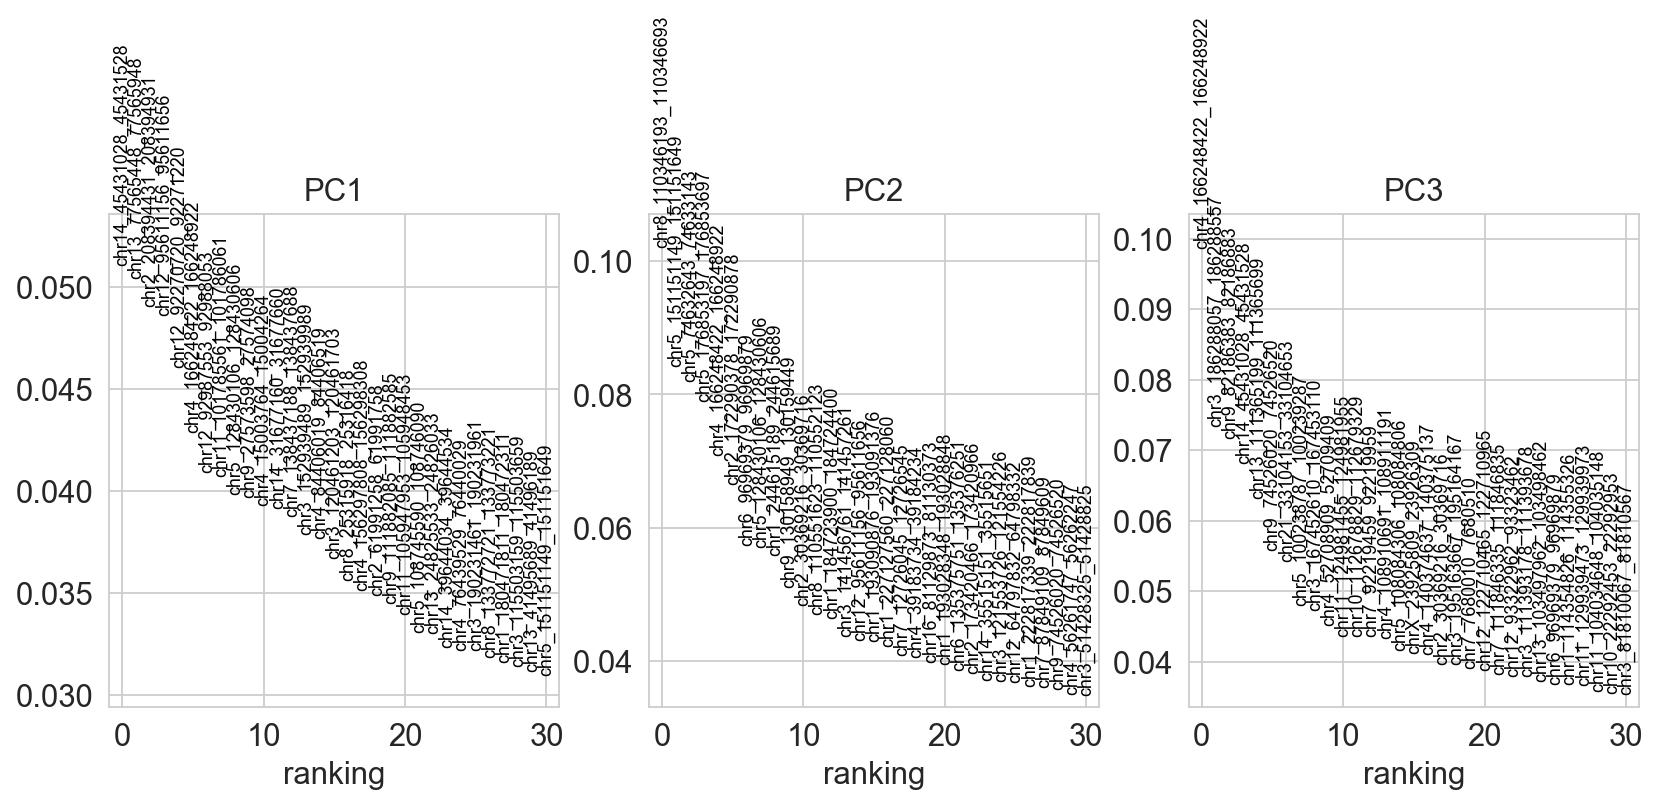

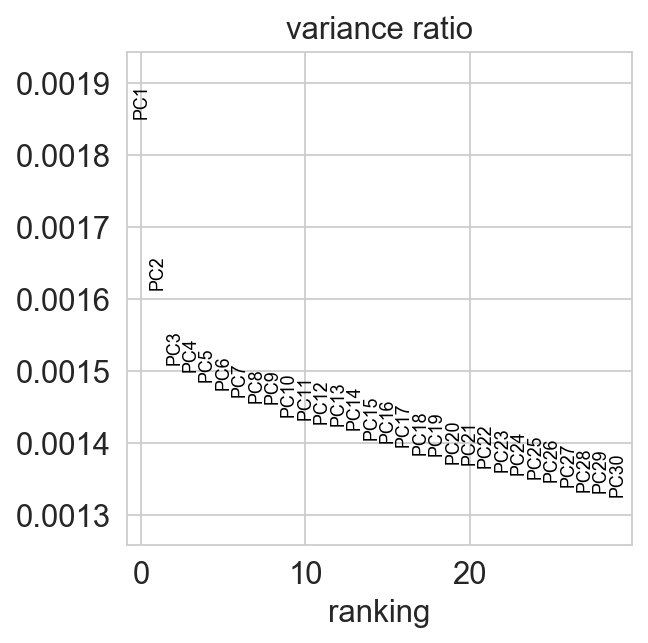

In [4]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))
print(adata)
# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)
#print(adata)

#epi.pp.commonness_features(adata, binary=True)
#epi.pp.coverage_cells(adata, binary=True)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=5)

#epi.pp.select_var_feature(adata, nb_features=50000)

epi.pp.commonness_features(adata, binary=True, log=True)
epi.pp.coverage_cells(adata, binary=True, log=True)

#sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
#                                      max_fraction=0.05, key_added=None, layers=None,
#                                      layer_norm=None, inplace=True)

#sc.pp.log1p(adata)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
#adata = adata[:, adata.var['highly_variable']]
print(adata)

adatareduced = adata.copy()
epi.pp.pca(adatareduced, n_comps=30)
sc.pl.pca_overview(adatareduced, color=['nb_features', 'n_features', 'cell_type'])

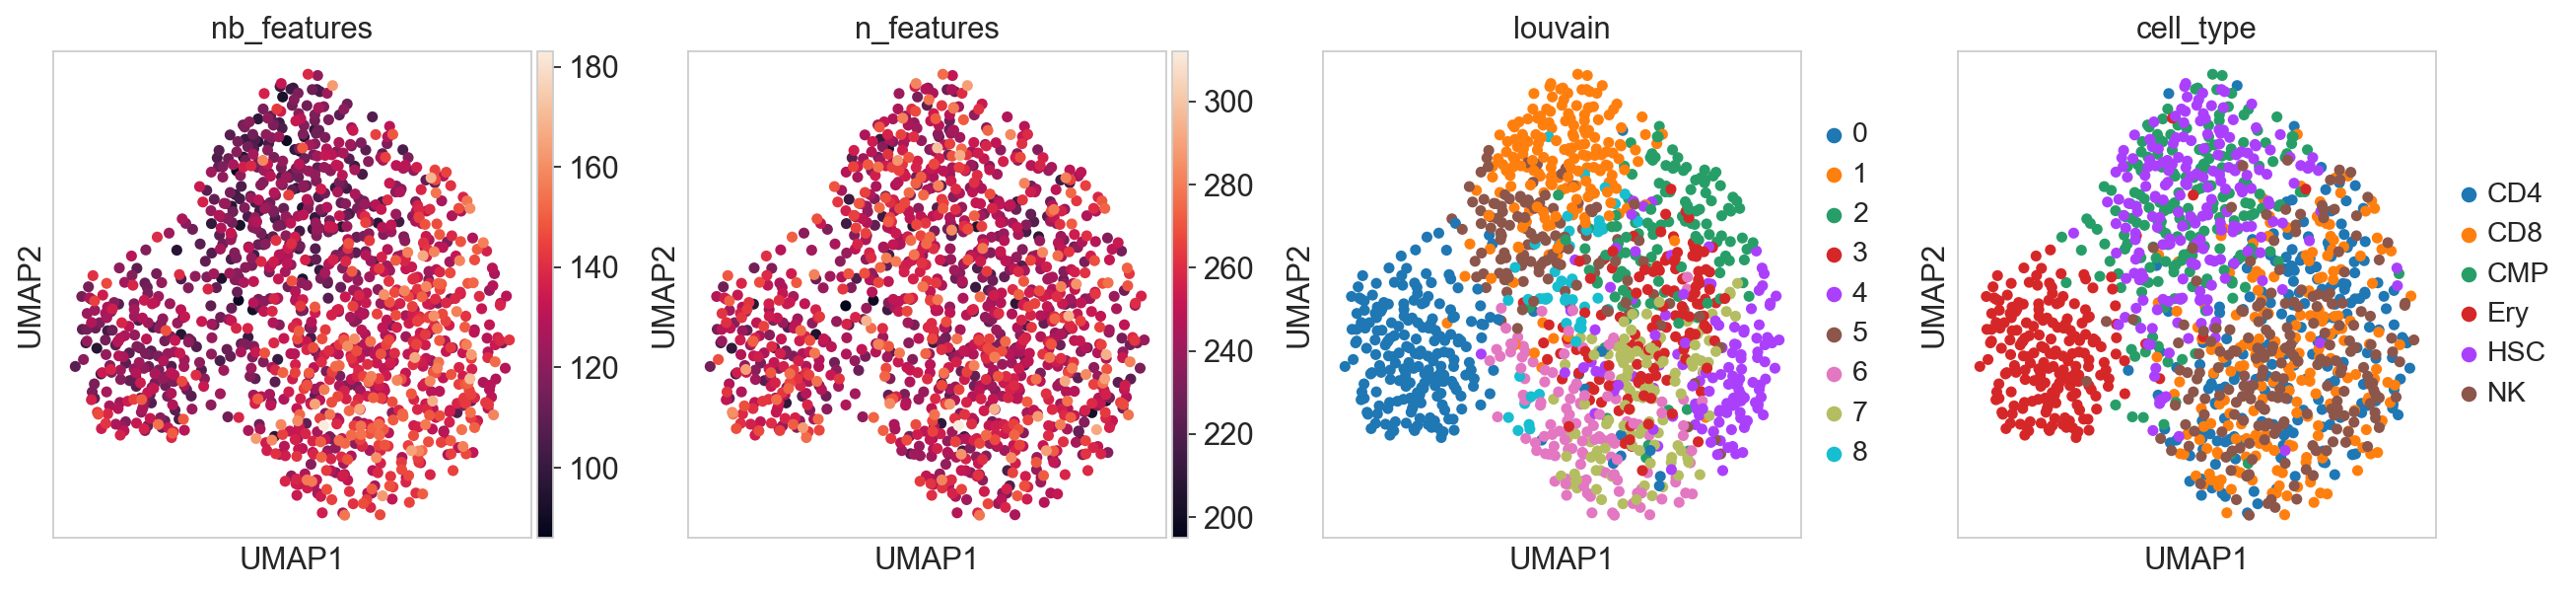

0.27131532768636973


In [11]:
epi.pp.pca(adatareduced, n_comps=10)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
epi.tl.louvain(adatareduced)
#sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cel  l_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

labels_true = adatareduced.obs['cell_type']
labels_pred = adatareduced.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

0.27131532768636973
step 0
got 15 at resolution 1.5
step 1
got 4 at resolution 0.75
step 2
got 9 at resolution 1.125
step 3
got 7 at resolution 0.9375
step 4
got 6 at resolution 0.84375


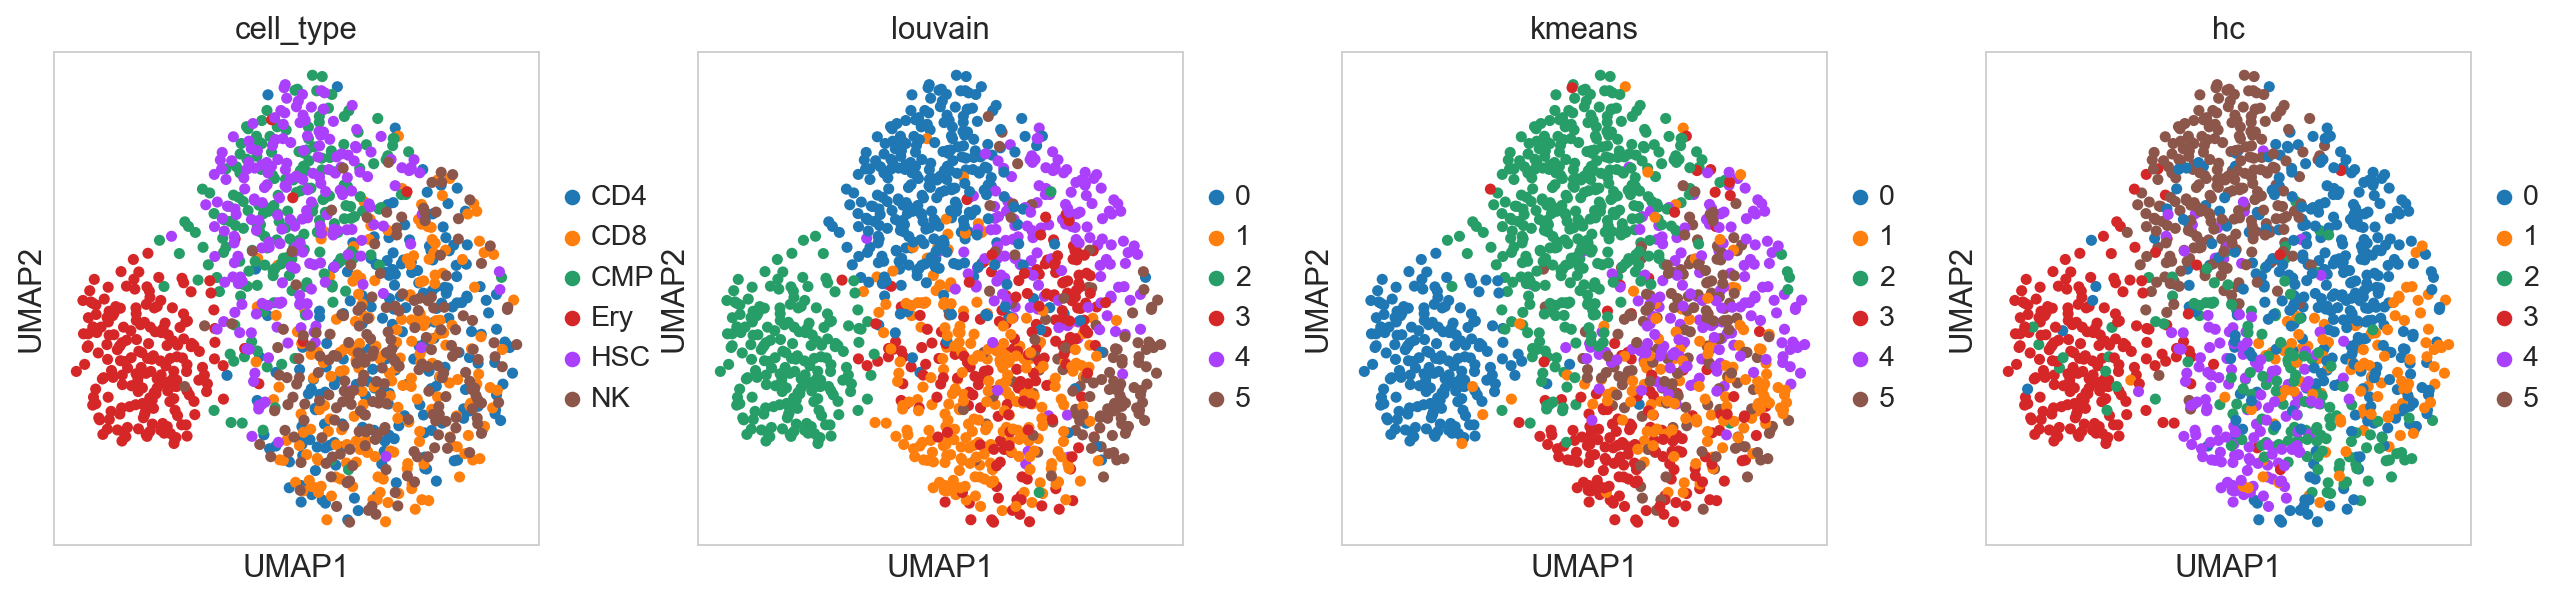

['BROCKMAN', '0.383853', '0.2704', '0.209239', '0.485115', '0.393496', '0.350152', '0.475787', '0.390847', '0.341665']
['Cusanovich2018', '0.463964', '0.466708', '0.453909', '0.567261', '0.695973', '0.658807', '0.554357', '0.552239', '0.520299']
['cisTopic', '0.23206', '0.237213', '0.1857', '0.26956', '0.300838', '0.258956', '0.272064', '0.304103', '0.256091']
['chromVAR_kmers', '0.157436', '0.187673', '0.100992', '0.171068', '0.239831', '0.132838', '0.172821', '0.242487', '0.134722']
['chromVAR_motifs', '0.0182829', '0.00421336', '0.00778921', '0.0270994', '0.00588628', '0.0110186', '0.0318046', '0.0116947', '0.0165816']
['chromVAR_kmers_pca', '0.213044', '0.206892', '0.131206', '0.246701', '0.257686', '0.166595', '0.249285', '0.261157', '0.165977']
['chromVAR_motifs_pca', '0.0181206', '0.00511444', '0.00831785', '0.0241337', '0.00706837', '0.0144193', '0.0293356', '0.0128519', '0.0198276']
['GeneScoring', '-0.000575516', '0.000181295', '8.45398e-05', '0.00028572', '0.000647666', '0.0

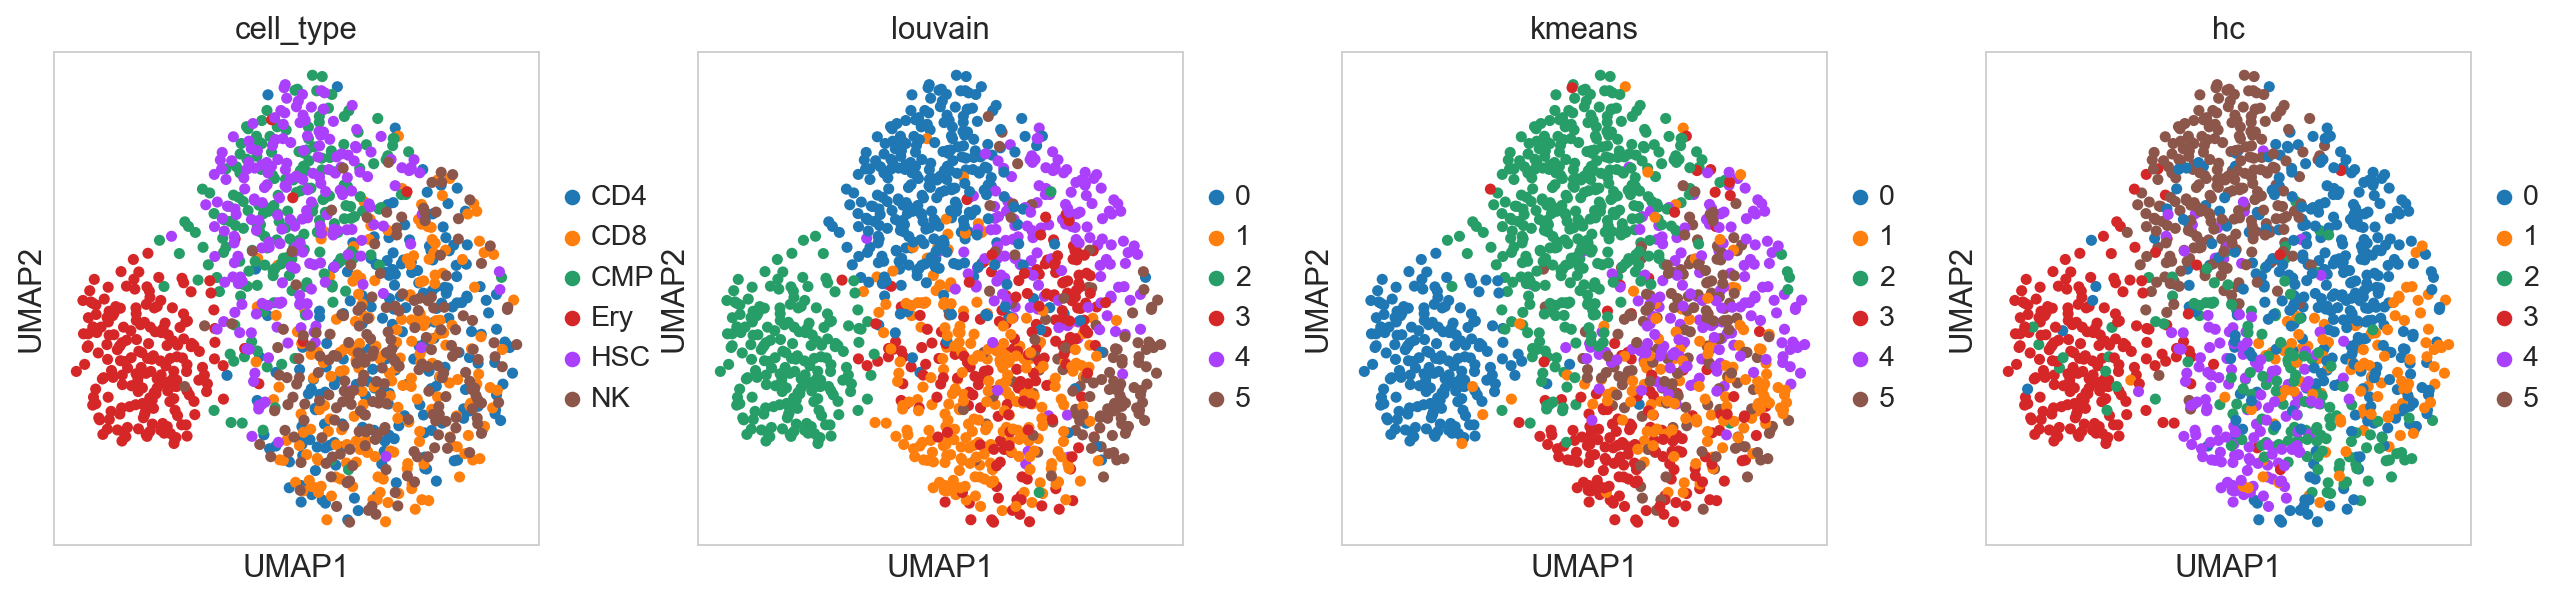

,ARI_Louvain,ARI_kmeans,ARI_HC,AMI_Louvain,AMI_kmeans,AMI_HC,Homogeneity_Louvain,Homogeneity_kmeans,Homogeneity_HC,method
epiScanpy-adata,0.286232,0.363521,0.251296,0.329009,0.417360,0.317576,0.328695,0.409325,0.314116,epiScanpy-adata
BROCKMAN,0.383853,0.270400,0.209239,0.485115,0.393496,0.350152,0.475787,0.390847,0.341665,BROCKMAN
Cusanovich2018,0.463964,0.466708,0.453909,0.567261,0.695973,0.658807,0.554357,0.552239,0.520299,Cusanovich2018
cisTopic,0.232060,0.237213,0.185700,0.269560,0.300838,0.258956,0.272064,0.304103,0.256091,cisTopic
chromVAR_kmers,0.157436,0.187673,0.100992,0.171068,0.239831,0.132838,0.172821,0.242487,0.134722,chromVAR_kmers
chromVAR_motifs,0.018283,0.004213,0.007789,0.027099,0.005886,0.011019,0.031805,0.011695,0.016582,chromVAR_motifs
chromVAR_kmers_pca,0.213044,0.206892,0.131206,0.246701,0.257686,0.166595,0.249285,0.261157,0.165977,chromVAR_kmers_pca
chromVAR_motifs_pca,0.018121,0.005114,0.008318,0.024134,0.007068,0.014419,0.029336,0.012852,0.019828,chromVAR_motifs_pca
GeneScoring,-0.000576,0.000181,0.000085,0.000286,0.000648,0.001106,0.006259,0.005673,0.007038,GeneScoring
GeneScoring_pca,0.004895,0.000220,0.000358,0.004586,0.003372,0.003999,0.009851,0.008500,0.008931,GeneScoring_pca


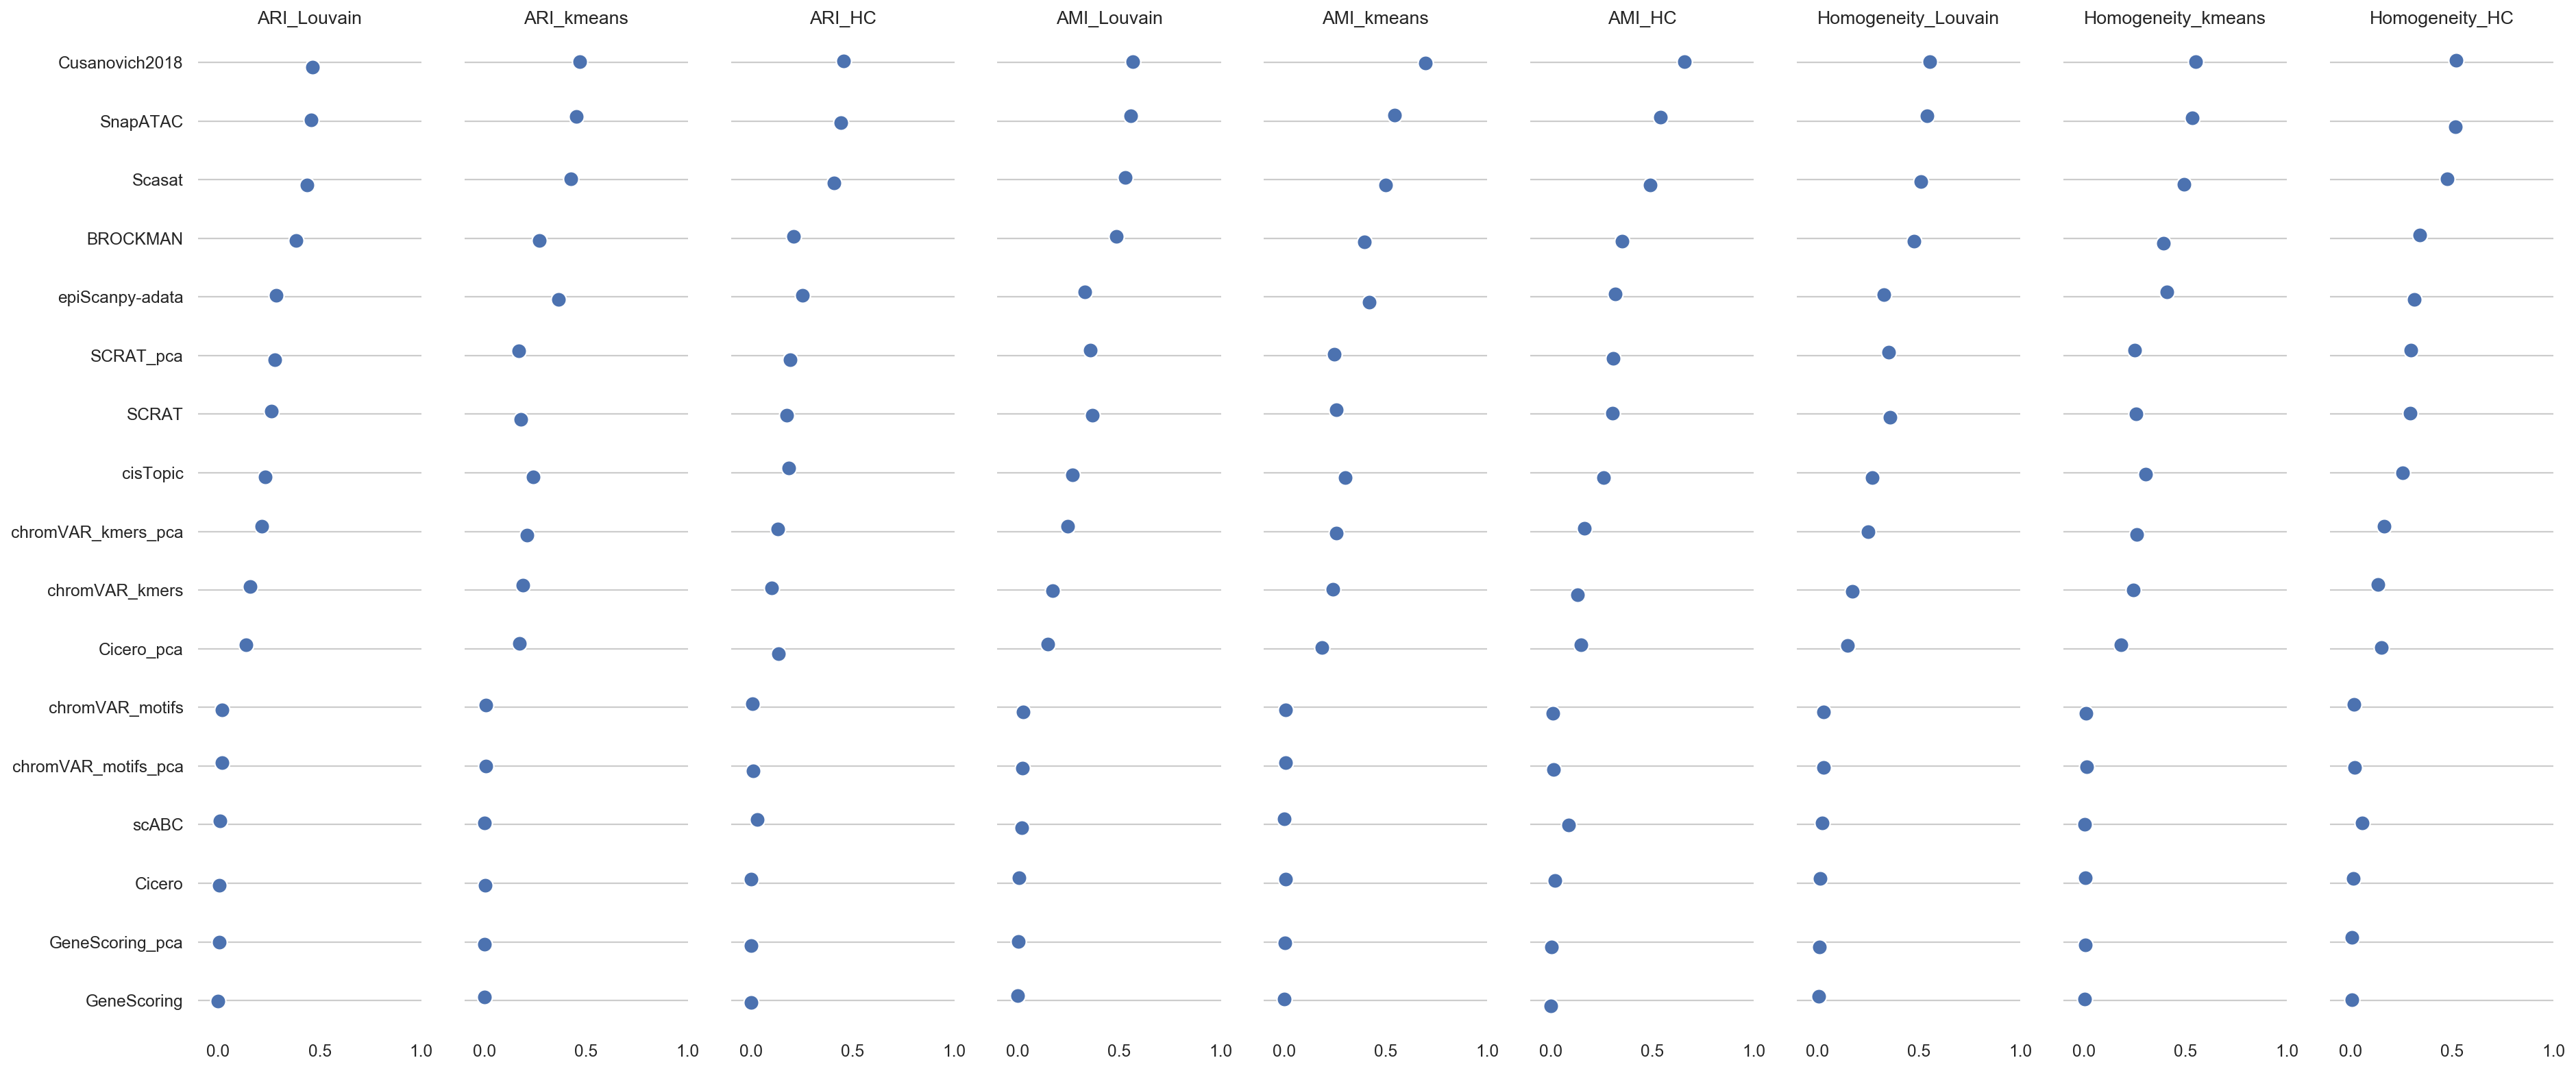

In [12]:
adata = adatareduced.copy()

from sklearn.metrics import adjusted_rand_score

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

############ Benchmarking
all_metrics = """Control	0.436509	0.432355	0.419495	0.519116	0.512964	0.496273	0.507425	0.506057	0.481675
BROCKMAN	0.383853	0.2704	0.209239	0.485115	0.393496	0.350152	0.475787	0.390847	0.341665
Cusanovich2018	0.463964	0.466708	0.453909	0.567261	0.695973	0.658807	0.554357	0.552239	0.520299
cisTopic	0.23206	0.237213	0.1857	0.26956	0.300838	0.258956	0.272064	0.304103	0.256091
chromVAR_kmers	0.157436	0.187673	0.100992	0.171068	0.239831	0.132838	0.172821	0.242487	0.134722
chromVAR_motifs	0.0182829	0.00421336	0.00778921	0.0270994	0.00588628	0.0110186	0.0318046	0.0116947	0.0165816
chromVAR_kmers_pca	0.213044	0.206892	0.131206	0.246701	0.257686	0.166595	0.249285	0.261157	0.165977
chromVAR_motifs_pca	0.0181206	0.00511444	0.00831785	0.0241337	0.00706837	0.0144193	0.0293356	0.0128519	0.0198276
GeneScoring	-0.000575516	0.000181295	8.45398e-05	0.00028572	0.000647666	0.00110577	0.0062593	0.00567277	0.00703753
GeneScoring_pca	0.00489502	0.000220458	0.000357904	0.00458554	0.00337199	0.00399909	0.00985128	0.00849958	0.00893085
Cicero	0.00511285	0.00129546	0.000676487	0.00749815	0.00551815	0.0189073	0.0132542	0.00840594	0.0157892
Cicero_pca	0.138344	0.169506	0.133869	0.147149	0.184575	0.150198	0.148612	0.183788	0.151371
SnapATAC	0.456709	0.452591	0.442317	0.554563	0.542329	0.539471	0.541368	0.532776	0.515763
Scasat	0.438832	0.422656	0.406995	0.528011	0.49924	0.490193	0.511236	0.493234	0.476979
scABC	0.0102605	-5.51497e-06	0.0295658	0.0190588	-0.000635829	0.0882195	0.0236311	0.00440851	0.059802
SCRAT	0.262336	0.176508	0.176186	0.367159	0.256473	0.30511	0.358151	0.258425	0.294334
SCRAT_pca	0.277325	0.166874	0.192388	0.356227	0.247448	0.305604	0.35154	0.250083	0.29697
"""

    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adata.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adata,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.obsm['X_pca'])
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adata.obs['label'], adata.obs['louvain'])
ari_kmeans = adjusted_rand_score(adata.obs['label'], adata.obs['kmeans'])
ari_hc = adjusted_rand_score(adata.obs['label'], adata.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adata.obs['label'], adata.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adata.obs['label'], adata.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adata.obs['label'], adata.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adata.obs['label'], adata.obs['louvain'])
homo_kmeans = homogeneity_score(adata.obs['label'], adata.obs['kmeans'])
homo_hc = homogeneity_score(adata.obs['label'], adata.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    print(line)
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_Louvain",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics